In [1]:
library(coda)
library(rjags)

Linked to JAGS 4.3.2

Loaded modules: basemod,bugs



# Exercise 1: Sampling Gaussian Mixture
Let $g(x, \mu, \sigma)$ be the un-normalized distribution of weighted mixture of two Gaussian distributions 
$$g(\theta|x) = \sum_{i=1}^2\ \phi_i N(\mu_i, \sigma_i)$$ where
- $\phi_0 = 0.6$ and $\phi_1 = 0.4$
- $\mu = \{-3,3\}$ and $\sigma = \{1,1\}$

Draw a Markov Chain from the posterior distribution using a Metropolis-Hastings algorithm, usings
a Norm (0, 1) as random-walk candidate density

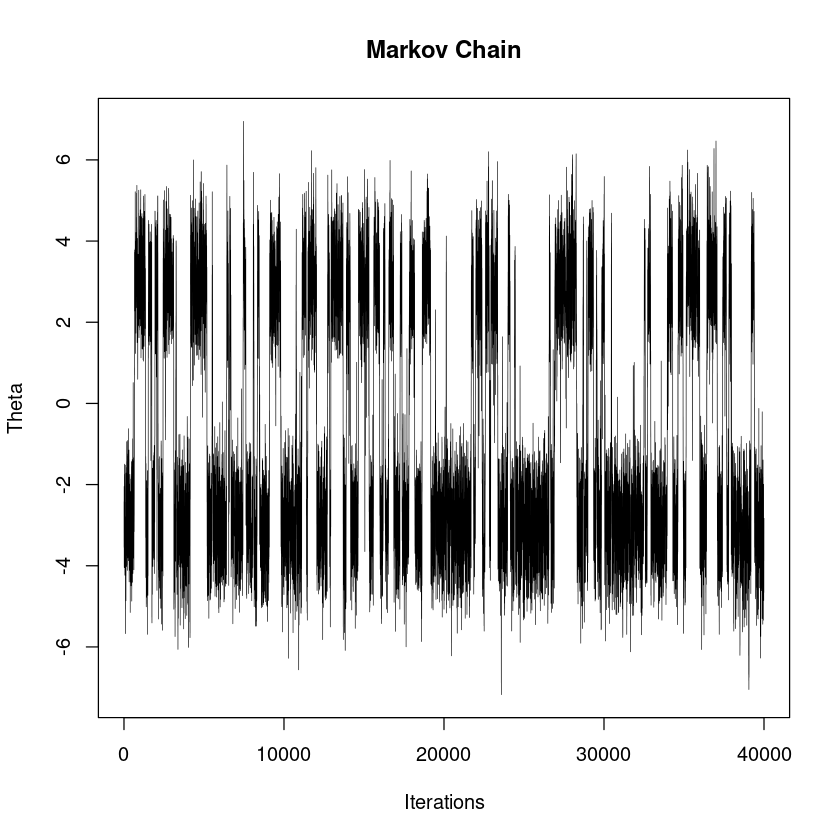

In [38]:
phi <- c(0.6, 0.4)
mu <- c(-3, 3)
sigma <- c(1, 1)

g <- function(theta) {
    sum(phi * dnorm(theta, mu, sigma))
}

n_steps <- 40000
theta_current <- 0
list_theta <- c()
for (i in 1:n_steps) {
    theta_hat <- theta_current + rnorm(1)
    alpha <- min(1, g(theta_hat)/g(theta_current))
    if (runif(1) < alpha) {
        theta_current <- theta_hat
    }
    list_theta <- c(list_theta, theta_current)
}
plot(list_theta, lwd=0.5, main="Markov Chain",
     type="l", xlab="Iterations", ylab="Theta"
)

Plot the sampled distribution

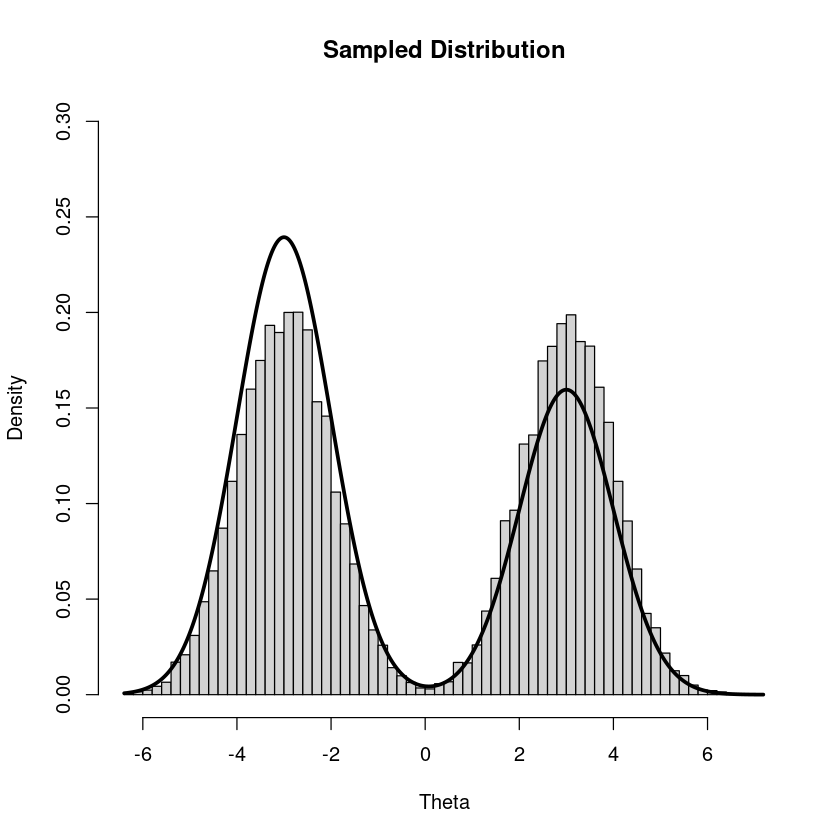

In [3]:
hist(list_theta, breaks=length(list_theta)^.4, 
     freq=FALSE, ylim=c(0,0.3),
     xlab="Theta", main="Sampled Distribution"
)
theta_range <- seq(min(list_theta), max(list_theta), length.out=1000)
y <- c()
for (theta in theta_range) {
    y <- c(y, g(theta))
}
lines(theta_range, y, lwd=3)

Evaluate the mean and the variance

In [4]:
theta_mean <- mean(list_theta)
theta_var <- var(list_theta)
cat("Mean:", theta_mean, "\nVar:", theta_var)

Mean: -0.02861649 
Var: 10.04887

Analyze the chain with the CODA package and plot the chain autocorrelation

Effective size: 149.4548

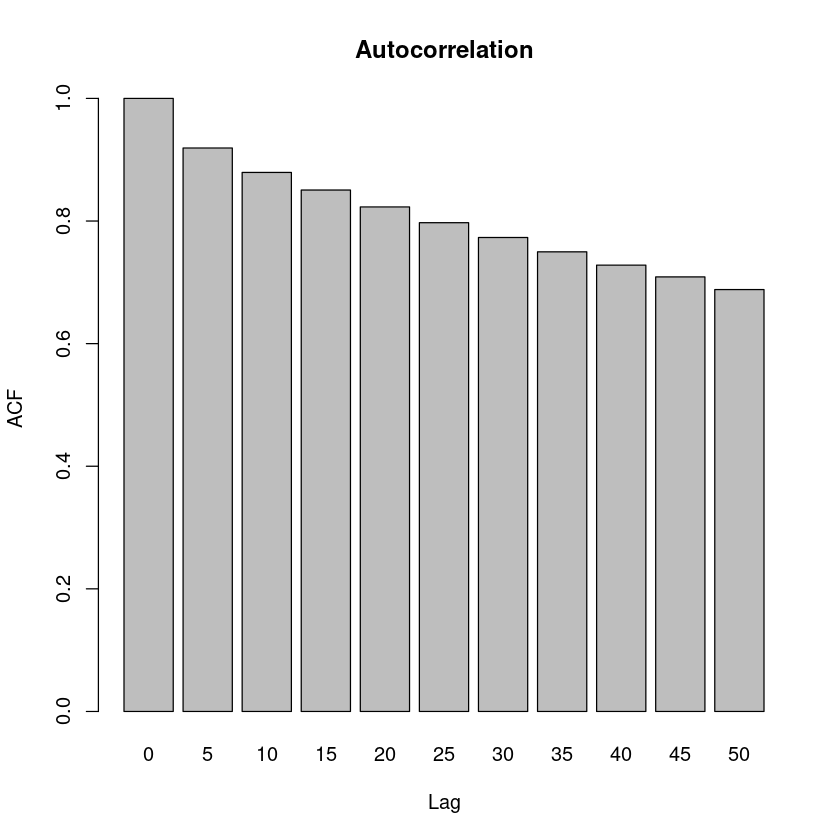

In [5]:
chain <- mcmc(list_theta)

plot_acf <- function(chain) {
    lags <- seq(0,50,5)
    acf <- autocorr(chain, lags=lags)
    barplot(as.numeric(acf),
            xlab = "Lag", ylab = "ACF",
            main = "Autocorrelation",
            names.arg = lags
    )
}

plot_acf(chain)
eff_size1 <- effectiveSize(chain)
cat("Effective size:", eff_size1)

Try different burn-in cycles and thinning, plot the related posterior distribution and the chain autocorrelation function. What are the best parameters?


Effective size for 1000 burn-in and
	- thinning by 5: 132.3404
	- thinning by 10: 127.7901
	- thinning by 15: 129.1484
	- thinning by 20: 118.5627

Effective size for 2000 burn-in and
	- thinning by 5: 129.5614
	- thinning by 10: 124.9893
	- thinning by 15: 124.9279
	- thinning by 20: 115.7376

Effective size for 3000 burn-in and
	- thinning by 5: 125.4682
	- thinning by 10: 115.6771
	- thinning by 15: 122.3909
	- thinning by 20: 111.2791

Effective size for 4000 burn-in and
	- thinning by 5: 126.05
	- thinning by 10: 116.3367
	- thinning by 15: 123.7739
	- thinning by 20: 112.6314

Best parameters: 4000 burn-in, thinning by 20

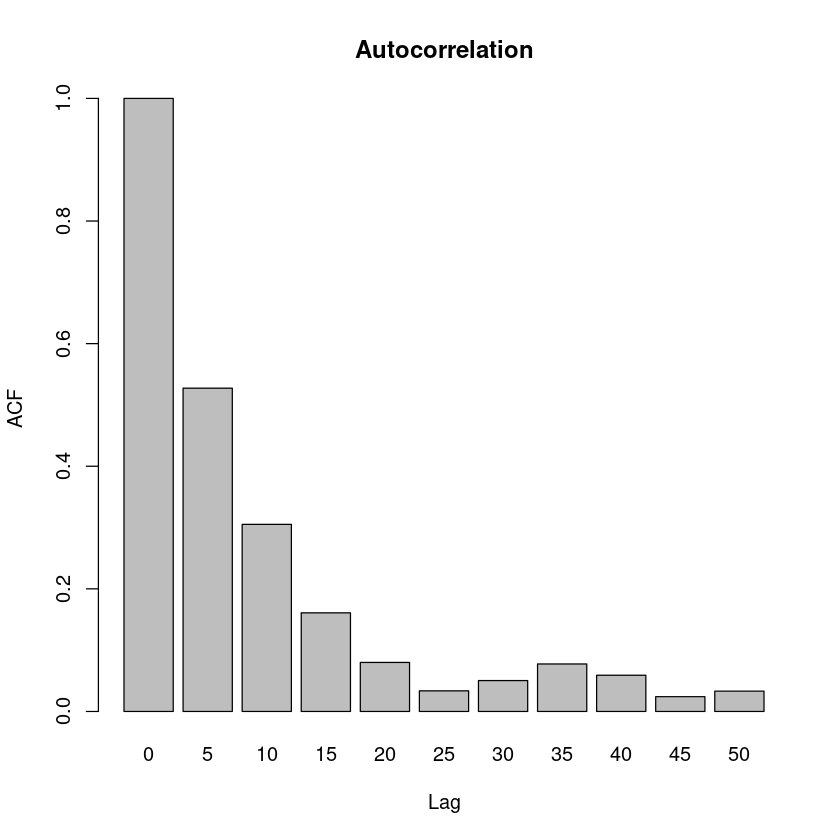

In [6]:
burnin_values <- c(1000, 2000, 3000, 4000)
thinning_values <- c(5, 10, 15, 20)

best_rate <- eff_size1 / n_steps
best_params <- c("no burn-in,", "thinning by 0")
best_chain <- chain
for (b in burnin_values) {
    cat("\nEffective size for ", b, " burn-in and\n", sep="")
    for (t in thinning_values) {
        burnin_ix <- b:length(list_theta)
        thinning_ix <- seq(1, length(burnin_ix), by = t)
        
        new_list_params <- list_theta[burnin_ix][thinning_ix]
        new_chain <- mcmc(new_list_params)
        eff_size <- effectiveSize(new_chain)

        cat("\t- thinning by ", t, ": ", eff_size, 
            "\n", sep="")
        
        current_rate <- eff_size / length(new_list_params)
        if (current_rate > best_rate) {
            best_rate <- current_rate
            best_params <- c(paste(b, "burn-in, "), 
                             paste("thinning by", t))
            best_chain <- new_chain
        }
        
    }
}

cat("\nBest parameters: ", best_params, sep="")
plot_acf(best_chain)

# Exercise 2: Gaussian model
Let
$$\vec{x} = \{ 13.427, 8.588, 10.908, 11.582, 11.011, 9.735, 13.779, 9.763 \}$$
be $n = 8$ observed data from a Gaussian distribution with unknown mean $m$ and variance $s^2$.

Assuming a uniform prior distributions for the parameters,
- ```m ~ dunif(-10,30)```
- ```s ~ dnorm(0,50)```

build a simple JAGS model and run a Markov Chain Monte Carlo to obtain the posterior distribution of the mean and variance.

In [61]:
x <- c(13.427, 8.588, 10.908, 11.582, 11.011, 9.735, 13.779, 9.763)

model_string <- "
model {
    m ~ dunif(-10, 30)
    s ~ dnorm(0, 50) T(0,)

    for (i in 1:n) {
        x[i] ~ dnorm(m, 1/s^2)
    }
    
    ratio <- m/s
}"
writeLines(model_string, "model.txt")

data <- list(x=x, n=length(x))
jags_model <- jags.model(
    "model.txt", data = data, n.chains = 3
)

update(jags_model, 1000)

chain <- coda.samples(
    jags_model, variable.names = c("m", "s", "ratio"), n.iter = 10000
)
file.remove("model.txt")

res <- summary(chain)$statistics
res

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 8
   Unobserved stochastic nodes: 2
   Total graph size: 21

Initializing model



[1] TRUE

,Mean,SD,Naive SE,Time-series SE
m,11.1025582,0.2788044,0.0016096778,0.0020177754
ratio,14.1649827,1.2664933,0.0073121026,0.0093567133
s,0.7895983,0.0679715,0.0003924337,0.0005120662


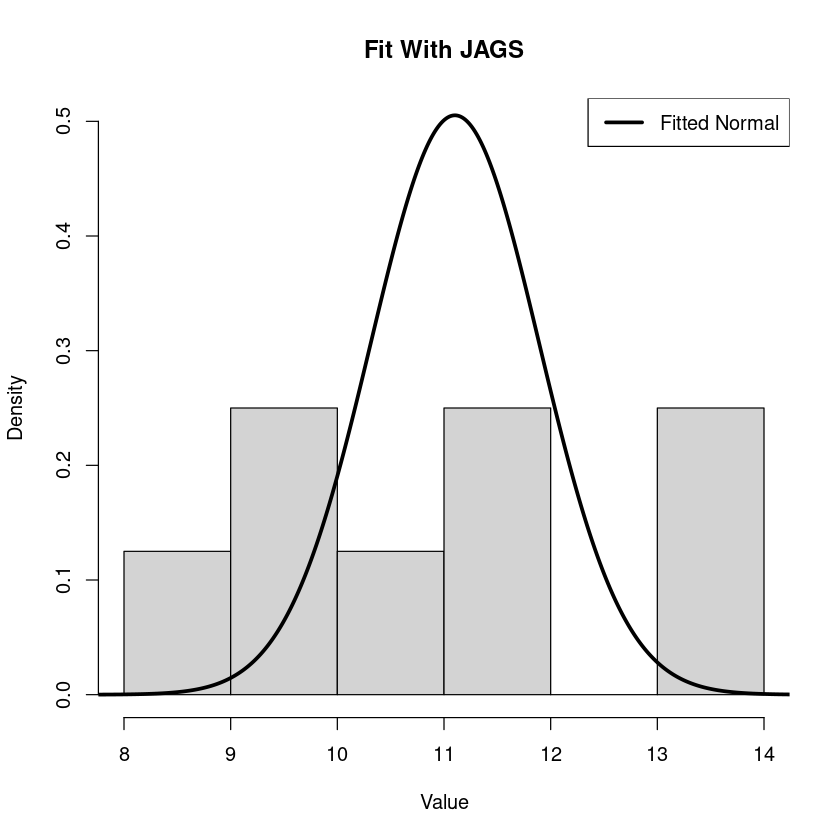

In [62]:
m_mean <- res["m", "Mean"]
s_mean <- res["s", "Mean"]

list_x <- seq(5,20,length.out=1000)
list_y <- dnorm(list_x, m_mean, s_mean)
hist(x, freq = FALSE, ylim = c(0,0.5),
     main = "Fit With JAGS", xlab = "Value"
)
lines(list_x, list_y, lwd = 3)
legend("topright", legend="Fitted Normal", lwd=3)

Compute the posterior distribution for $m/s$

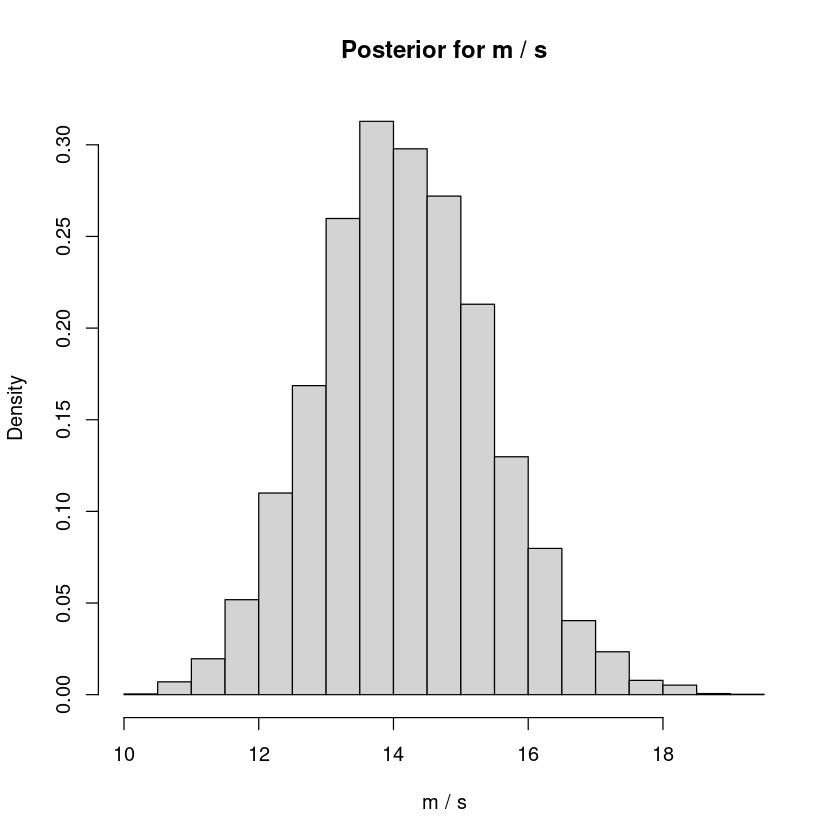

In [66]:
ratio_samples <- chain[,"ratio"][[1]]
hist(ratio_samples, freq = FALSE,
     xlab = "m / s",
     main = "Posterior for m / s"
)

# Exercise 3 : Power Law fitting
Using R, generate 100 synthetic data from power law distribution
$$p(x | \alpha, x_{min}) = \frac{\alpha-1}{x_{min}} \left( \frac{x}{x_{min}} \right)^{-\alpha}, \quad x \ge x_{min}$$
with fixed $x_{min} = 10$ and power law exponent $\alpha = 2.5$

Assuming $x_{min}$ fixed and $\alpha$ unknown, build JAGS models using the priors
- ```alpha ∼ dunif(1.01, 10)```
- ```alpha ∼ dnorm(2.5, 100)```

Run MCMC to get the posterior distribution. Evaluate the mean, the most probable value, the credibility interval at 95% level.

Compare the Bayesian estimate for $\alpha$ with the one achieved in frequentist setting.